In [1]:
from __future__ import print_function
import os
from os import path

import sys
import numpy as np
np.random.seed(1337)

import pandas as pd

### Importing texts

In [2]:
# check if file exists
print ("File exists:"+str(path.exists("ABSACOMBINED.csv")))

# import text and remove those with null category
input_data = pd.read_csv("ABSACOMBINED.csv")
print('Before removing NaN value: ', input_data.shape)
input_data = input_data.dropna(subset=['category'])
print('After removing NaN value: ', input_data.shape)
print(input_data.head(5))

# define data grouped by review id (as dataframe)
grouped_df = input_data.groupby('review_id')
actual_category = grouped_df['category'].agg(lambda column: ",".join(column))
actual_category = actual_category.reset_index(name='category')

# define x_train and y_train data
review_id = input_data.review_id
phrase = input_data.phrase
category = input_data.category
print(category.value_counts())

File exists:True
Before removing NaN value:  (5055, 5)
After removing NaN value:  (5055, 5)
   review_id                                             phrase  \
0          0     judging previous posts used good place longer    
1          1    four arrived noon place empty staff acted like    
2          1  four arrived noon place empty staff acted like...   
3          1              empty staff acted like imposing rude    
4          2        repeated requests sugar threw dishes table    

             category aspect_term  polarity  
0  RESTAURANT#GENERAL       posts  negative  
1     SERVICE#GENERAL       staff  negative  
2     SERVICE#GENERAL        rude  negative  
3     SERVICE#GENERAL        rude  negative  
4     SERVICE#GENERAL         eat  negative  
FOOD#QUALITY                1709
SERVICE#GENERAL              902
AMBIENCE#GENERAL             581
RESTAURANT#GENERAL           535
FOOD#STYLE_OPTIONS           379
DRINKS#QUALITY               191
FOOD#PRICES                  17

In [3]:
MAX_SEQ_LENGTH = 10  # most of the phrase is within length of 10
MAX_NB_WORDS = 400000  # I set this based on the number of words found in the glove.txt (should have no effect as only 2744 tokens found below) 
EMBEDDING_DIM = 100  # I tried using glove 100d

#### vectorize the text samples into a 2D integer tensor and padding the sentences

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)
tokenizer.fit_on_texts(phrase)
sequences = tokenizer.texts_to_sequences(phrase)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print ("Let's have a quick look at the word_index data..")
print (list(word_index.items())[:10])

Using TensorFlow backend.


Found 2890 unique tokens.
Let's have a quick look at the word_index data..
[('food', 1), ('great', 2), ('good', 3), ('service', 4), ('place', 5), ('best', 6), ('nice', 7), ('like', 8), ('restaurant', 9), ('excellent', 10)]


In [5]:
tokenised_sequence = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
print(tokenised_sequence)
print('Shape of tokenised output:', tokenised_sequence.shape)

[[2232 1489 2233 ...    0    0    0]
 [ 416  876 1780 ...    8    0    0]
 [ 416  876 1780 ...    8 1781  111]
 ...
 [   3    1   57 ...    0    0    0]
 [   3    1   57 ...    0    0    0]
 [   3    1   57 ...    0    0    0]]
Shape of tokenised output: (5055, 10)


#### defining output data

In [6]:
review_id_list = review_id.tolist()
category_list = category.tolist()

In [7]:
from collections import Counter
from sklearn.utils import class_weight

class_list = ['FOOD#QUALITY', 'SERVICE#GENERAL', 'AMBIENCE#GENERAL', 'RESTAURANT#GENERAL']
filtered_phrase = []
filtered_category = []
filtered_id = []

for i in range(len(category_list)):  # to choose the top 4 largest class
    if category_list[i] in class_list:
        filtered_id.append(review_id_list[i])
        filtered_phrase.append(tokenised_sequence[i])
        filtered_category.append(category_list[i])
        
np_phrase = np.array(filtered_phrase)  # So this is without oversampling, the accuracy improves from 0.2 to 0.4 but still all same prob
np_category = np.array(filtered_category)
print(sorted(Counter(np_category).items()))

# class weight to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np_category),
                                                 np_category)
print(class_weights)

[('AMBIENCE#GENERAL', 581), ('FOOD#QUALITY', 1709), ('RESTAURANT#GENERAL', 535), ('SERVICE#GENERAL', 902)]
[1.60370052 0.54520187 1.74158879 1.03298226]


**transform output data into categorical index**

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(np_category)
    
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
print(onehot_encoded.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
(3727, 4)


**Tidy up all variables**

In [9]:
# 80% as training data
# 20% as testing data
import math

phrase_size = np_phrase.shape[0]
category_size = onehot_encoded.shape[0]
assert phrase_size == category_size

train_limit = math.ceil(category_size*0.8)
test_limit = category_size

x_train = np_phrase[:train_limit]
x_test = np_phrase[train_limit:test_limit]
y_train = onehot_encoded[:train_limit]
y_test = onehot_encoded[train_limit:test_limit]
id_test = filtered_id[train_limit:test_limit]

print("Train with " + str(train_limit))
print("Test with " + str(test_limit - train_limit))

Train with 2982
Test with 745


#### Indexing Word Vectors

In [10]:
print('Indexing word vectors.')

embeddings_index = {}

# check if file exists
print ("File exists:"+str(path.exists("glove.6B.100d.txt")))

f = open("glove.6B.100d.txt", 'rb')
for line in f:
    values = line.split()
    word = values[0]
    word = word.decode("utf-8")
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
File exists:True
Found 400000 word vectors.


#### Preparing Embedding Layer

In [11]:
from keras.layers import Embedding

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = len(word_index)
embedding_matrix = np.zeros((nb_words + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(nb_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LENGTH,
                            trainable=False)

Preparing embedding matrix.


### Defining and Training Model

In [12]:
from keras.models import Sequential, Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.preprocessing import sequence
from keras.optimizers import *
from keras.regularizers import l2
from keras.layers import Dense, Input, Flatten
from keras.layers import Dense, LSTM, SpatialDropout1D
from keras.layers import BatchNormalization
import keras

In [13]:
# choose the model with best hyperparameter

lstm_out = 10

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.36))
model.add(LSTM(lstm_out, dropout= 0.36, recurrent_dropout=0.36))
model.add(BatchNormalization())
model.add(Dense(8,activation='softmax'))
model.add(Dense(4,activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

history = model.fit(x_train, y_train,  # 80% as training data
      validation_split=0.1,
      batch_size=64,
      epochs=50, class_weight = class_weights)

Train on 2683 samples, validate on 299 samples
Epoch 1/50
2683/2683 [==============================] - 2s 783us/step - loss: 1.3676 - accuracy: 0.3392 - val_loss: 1.3271 - val_accuracy: 0.4849
Epoch 2/50
2683/2683 [==============================] - 1s 228us/step - loss: 1.3158 - accuracy: 0.4428 - val_loss: 1.2888 - val_accuracy: 0.4916
Epoch 3/50
2683/2683 [==============================] - 1s 248us/step - loss: 1.2714 - accuracy: 0.4715 - val_loss: 1.2461 - val_accuracy: 0.5050
Epoch 4/50
2683/2683 [==============================] - 1s 248us/step - loss: 1.2411 - accuracy: 0.4845 - val_loss: 1.2072 - val_accuracy: 0.5318
Epoch 5/50
2683/2683 [==============================] - 1s 228us/step - loss: 1.2183 - accuracy: 0.4987 - val_loss: 1.1749 - val_accuracy: 0.5485
Epoch 6/50
2683/2683 [==============================] - 1s 229us/step - loss: 1.1960 - accuracy: 0.5002 - val_loss: 1.1548 - val_accuracy: 0.5652
Epoch 7/50
2683/2683 [==============================] - 1s 219us/step - loss:

In [14]:
import joblib
filename = 'finalized_hybrid_lstm_aspect.sav'
joblib.dump(model, filename)

['finalized_hybrid_lstm_aspect.sav']

In [15]:
# import scikit-learn svc
from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, r2_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [16]:

# extracing 
outputs = []
test_outputs = []
for i in range(3, 4):
    layer = model.layers[i]
    keras_function = K.function([model.input], [layer.output])
    outputs.append(keras_function([x_train, 1]))
    test_outputs.append(keras_function([x_test, 1]))

In [17]:
test_outputs

[[array([[-1.19888   , -0.11356947,  1.3258862 , ...,  1.5387826 ,
           1.0630138 ,  1.8872415 ],
         [-1.4313204 , -0.10613298,  1.3198662 , ...,  1.5109174 ,
           1.3209994 ,  1.9680167 ],
         [-1.2400427 , -0.00472283,  1.0187469 , ...,  0.71923274,
           0.7128395 ,  0.09538423],
         ...,
         [-1.0883331 , -0.01495156, -0.38098383, ..., -0.764333  ,
           0.8107233 ,  1.6966351 ],
         [-1.2690544 ,  0.6729776 ,  0.8600092 , ...,  0.48117143,
           0.6192038 , -0.30581608],
         [-1.2690542 ,  0.6729781 ,  0.8600092 , ...,  0.48117143,
           0.6192038 , -0.30581632]], dtype=float32)]]

In [18]:
# import scikit-learn's scaler
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
svm_asp_train = np.array(outputs)
svm_asp_test = np.array(test_outputs)

# svm_asp_train : aspect training data for svm classifier
reshaped_svm_asp_train = np.reshape(svm_asp_train, (train_limit * 10))
svm_asp_train = np.reshape(reshaped_svm_asp_train, (train_limit, 10))

# svm_asp_test : aspect testing data for svm classifier
reshaped_svm_asp_test = np.reshape(svm_asp_test, ((test_limit - train_limit) * 10))
svm_asp_test = np.reshape(reshaped_svm_asp_test, ((test_limit - train_limit), 10))

In [19]:
# decode onehot_encoded 
print(y_train)
y_labels = np.argmax(y_train, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [20]:
best_acc_for_each = []
best_c_for_each = []

In [46]:
# run 1a : 
# kernel = "rbf"
# scaler : minmax
# c : 1 to 70 

# multiple runs of rbf kernel with different C scaled with minmaxscaler
acc = []
acc_val = []
for i in range(1, 71):
    svm = make_pipeline(mm_scaler, SVC(C = i, kernel = 'rbf', gamma="auto"))
    svm.fit(svm_asp_train, y_labels)
    svm.predict(svm_asp_test)
    acc.append(svm.score(svm_asp_test, y_test_labels, sample_weight=None))
best_acc_for_each.append(max(acc))
best_c_for_each.append(acc.index(max(acc)))

In [47]:
print(acc[0])
print(acc[29])
print(acc[69])

0.702013422818792
0.6993288590604027
0.697986577181208


Maximum accuracy is first attained at C : 0


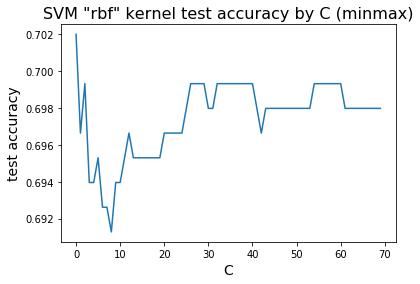

In [23]:
# plot accuracy for multiple runs of rbf kernel with different C scaled with minmaxscaler
x = list(range(70))
y = acc
plt.plot(x,y)
plt.xlabel("C", size=14)
plt.ylabel("test accuracy", size=14)
plt.title('SVM "rbf" kernel test accuracy by C (minmax)', size=16)
print("Maximum accuracy is first attained at C : " + str(acc.index(max(acc))))

In [48]:
# run 1b : 
# kernel = "linear"
# scaler : minmax
# c : 1 to 70 

# multiple runs of linear kernel with different C scaled with minmaxscaler
acc = []
for i in range(1, 71):
    svm = make_pipeline(mm_scaler, SVC(C = i, kernel = 'linear', gamma="auto"))
    svm.fit(svm_asp_train, y_labels)
    svm.predict(svm_asp_test)
    acc.append(svm.score(svm_asp_test, y_test_labels, sample_weight=None))
best_acc_for_each.append(max(acc))
best_c_for_each.append(acc.index(max(acc)))

In [49]:
print(acc[0])
print(acc[29])
print(acc[69])

0.6926174496644295
0.6912751677852349
0.6926174496644295


Maximum accuracy is first attained at C : 2


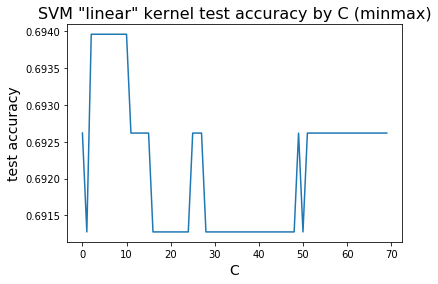

In [26]:
# plot accuracy for multiple runs of linear kernel with different C scaled with minmaxscaler
x = list(range(70))
y = acc
plt.plot(x,y)
plt.xlabel("C", size=14)
plt.ylabel("test accuracy", size=14)
plt.title('SVM "linear" kernel test accuracy by C (minmax)', size=16)
print("Maximum accuracy is first attained at C : " + str(acc.index(max(acc))))

In [27]:
# run 1c : 
# kernel = "rbf"
# scaler : standard
# c : 1 to 70 

# multiple runs of rbf kernel with different C scaled with StandardScaler
acc = []
for i in range(1, 71):
    svm2 = make_pipeline(StandardScaler(), SVC(C = i, kernel = 'rbf', gamma="auto"))
    svm2.fit(svm_asp_train, y_labels)
    svm2.predict(svm_asp_test)
    acc.append(svm2.score(svm_asp_test, y_test_labels, sample_weight=None))
best_acc_for_each.append(max(acc))
best_c_for_each.append(acc.index(max(acc)))

In [28]:
print(acc[0])
print(acc[29])
print(acc[69])

0.6939597315436241
0.6832214765100671
0.6738255033557047


Maximum accuracy is first attained at C : 0


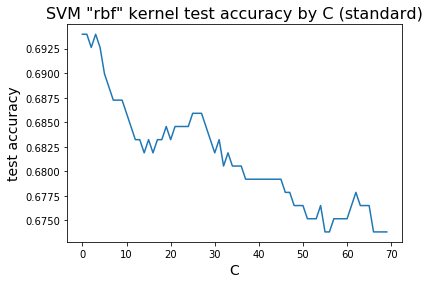

In [29]:
# plot accuracy for multiple runs of rbf kernel with different C scaled with StandardScaler
x = list(range(70))
y = acc
plt.plot(x,y)
plt.xlabel("C", size=14)
plt.ylabel("test accuracy", size=14)
plt.title('SVM "rbf" kernel test accuracy by C (standard)', size=16)
print("Maximum accuracy is first attained at C : " + str(acc.index(max(acc))))

In [30]:
# run 1d : 
# kernel = "linear"
# scaler : standard
# c : 1 to 70 

# multiple runs of linear kernel with different C scaled with StandardScaler
acc = []
for i in range(1, 71):
    svm = make_pipeline(StandardScaler(), SVC(C = i, kernel = 'linear', gamma="auto"))
    svm.fit(svm_asp_train, y_labels)
    svm.predict(svm_asp_test)
    acc.append(svm.score(svm_asp_test, y_test_labels, sample_weight=None))
best_acc_for_each.append(max(acc))
best_c_for_each.append(acc.index(max(acc)))

In [31]:
print(acc[0])
print(acc[29])
print(acc[69])

0.6912751677852349
0.6912751677852349
0.6912751677852349


Maximum accuracy is first attained at C : 1


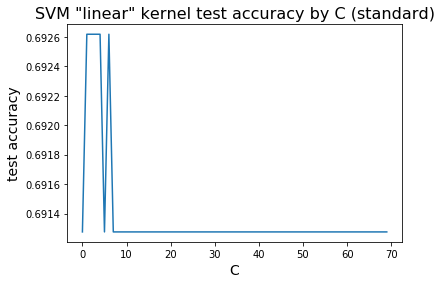

In [32]:
# plot accuracy for multiple runs of linear kernel with different C scaled with StandardScaler
x = list(range(70))
y = acc
plt.plot(x,y)
plt.xlabel("C", size=14)
plt.ylabel("test accuracy", size=14)
plt.title('SVM "linear" kernel test accuracy by C (standard)', size=16)
print("Maximum accuracy is first attained at C : " + str(acc.index(max(acc))))

# till here 

In [33]:
all_options = [[mm_scaler, 'rbf'], [mm_scaler, 'linear'], [StandardScaler(), 'rbf'], [StandardScaler(), 'linear']]
optimum_model = all_options[best_acc_for_each.index(max(best_acc_for_each))]
optimum_c = best_c_for_each[best_acc_for_each.index(max(best_acc_for_each))]

chosen = make_pipeline(optimum_model[0], SVC(C = optimum_c + 1, kernel = optimum_model[1], gamma="auto"))
chosen.fit(svm_asp_train, y_labels)
res = chosen.predict(svm_asp_test)
print(chosen.score(svm_asp_test, y_test_labels, sample_weight=None))

0.702013422818792


In [34]:
pre_res = label_encoder.inverse_transform(res)
print(pre_res)
df = pd.DataFrame({'review_id': id_test,
     'predicted_category': pre_res})
#print(df)
predicted_data = df.groupby('review_id')['predicted_category'].apply(lambda x : ','.join(x))
predicted_data

['FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'SERVICE#GENERAL'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'SERVICE#GENERAL'
 'RESTAURANT#GENERAL' 'RESTAURANT#GENERAL' 'SERVICE#GENERAL'
 'SERVICE#GENERAL' 'FOOD#QUALITY' 'AMBIENCE#GENERAL' 'RESTAURANT#GENERAL'
 'RESTAURANT#GENERAL' 'SERVICE#GENERAL' 'AMBIENCE#GENERAL'
 'AMBIENCE#GENERAL' 'AMBIENCE#GENERAL' 'AMBIENCE#GENERAL'
 'SERVICE#GENERAL' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'AMBIENCE#GENERAL' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'AMBIENCE#GENERAL' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY' 'FOOD#QUALITY'
 'FOOD#QUALITY' 'FOOD#QUALITY' 'SERVICE#GENERAL' 'FOOD#QUALI

review_id
2114    FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY,SERVICE...
2115               FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY
2127                                         FOOD#QUALITY
2130                                         FOOD#QUALITY
2135    FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY,FOOD#QU...
                              ...                        
2800                                         FOOD#QUALITY
2801                                         FOOD#QUALITY
2802                                         FOOD#QUALITY
2805                                         FOOD#QUALITY
2807                                         FOOD#QUALITY
Name: predicted_category, Length: 404, dtype: object

In [35]:
misclassified = [0, 0, 0, 0]
np_category = ['AMBIENCE#GENERAL', 'FOOD#QUALITY', 'RESTAURANT#GENERAL', 'SERVICE#GENERAL']

In [36]:
# to see how many sentence got all the categories right
no_of_sentence = predicted_data.size
no_of_sentence_correct = 0
for index, value in predicted_data.items():
    match = True
    predicted_value = value.split(',')
    actual_value = actual_category[actual_category['review_id'] == index]['category']
    actual_value = actual_value.tolist()[0].split(',')
    for elem in actual_value:
        if elem not in predicted_value:
            match = False
            misclassified[np_category.index(elem)] += 1 
            break
    if match:
        no_of_sentence_correct += 1

print(no_of_sentence_correct/no_of_sentence)
print(misclassified)

0.7623762376237624
[17, 25, 23, 31]


In [37]:
filename = 'finalized_hybrid_svm_aspect.sav'
joblib.dump(chosen, filename)

['finalized_hybrid_svm_aspect.sav']

In [38]:
actual_category.to_csv("hybrid_actual_category.csv")
predicted_data.to_csv("hybrid_predicted_category.csv")

/Users/KeeJay/Downloads/FYP/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### User Input


In [39]:
java_path = "C:/Program Files/Java/jdk-11.0.2/bin/java.exe"
# java_path = "C:/Program Files/Java/jdk1.8.0_201/bin/java.exe"
os.environ['JAVA_HOME'] = java_path 

#For stanford POS Tagger
home = os.getcwd() + "/stanford-postagger-2018-10-16"
from nltk.tag.stanford import StanfordPOSTagger as POS_Tag
from nltk import word_tokenize
_path_to_model = home + '/models/english-bidirectional-distsim.tagger' 
_path_to_jar = home + '/stanford-postagger.jar'
stanford_tag = POS_Tag(model_filename=_path_to_model, path_to_jar=_path_to_jar)

In [40]:
#To tag using stanford pos tagger
def posTag(review):
    tagged_text_list=[]
    for text in review:
        tagged_text_list.append(stanford_tag.tag(word_tokenize(text)))
    return tagged_text_list

#Filter the word with tag- noun,adjective,verb,adverb
def filterTag(tagged_review):
    final_text_list=[]
    for text_list in tagged_review:
        final_text=[]
        for word,tag in text_list:
            if tag in ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']:
                final_text.append(word)
        final_text_list.append(' '.join(final_text))
    return final_text_list


In [41]:
import nltk
from nltk.tokenize import word_tokenize 
from spellchecker import SpellChecker
import string
import re

# Reduce duplicated letters in a word to be maximum of 2.

def word_lengthening(sentence):
    list_words = sentence
    pattern = re.compile(r"(.)\1{2,}")
    reduced_list = [pattern.sub(r"\1\1", word) for word in list_words] # Perform reduce lenghtening
    return reduced_list

In [42]:
# Perform spell correction
# Downside: Some names/abbreviations are also used for spell correction which could cause some inconsistency.

spell = SpellChecker()

def spell_correction(sentence):
    list_words = sentence
    spell_list = [spell.correction(word) for word in list_words]
    return spell_list

In [43]:
# Remove punctuations from all sentences
def remove_punct(my_sentence):
    trans_table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    no_punct = my_sentence.translate(trans_table)
    return no_punct

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_df=1.0,stop_words='english')  

In [45]:
#Aspect analyis of user's input.
user_input=input("Enter a restaurant review:\n\n")

# Remove punctuations from sentence
user_input = remove_punct(user_input)

# Tokenize input sentence
token_input = nltk.word_tokenize(user_input)
print("Tokenize words: ", token_input)

# Perform word correction
word_correction = word_lengthening(token_input)
correct_sentence = spell_correction(word_correction)
joined_words = ( " ".join(correct_sentence))
print("Spelling correction: ", joined_words)

#Preprocessing and vectorizing
tagged_user_input = posTag([joined_words])
print("Part-of-Speech Tagging: ", tagged_user_input)
filter_tagged_user_input = filterTag(tagged_user_input)
print("Filtered Part-of-Speech Tagging: ", filter_tagged_user_input)

sequences = tokenizer.texts_to_sequences(filter_tagged_user_input)
tokenised_sequence = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
np_phrase = np.array(tokenised_sequence)

outputs = []
for i in range(3, 4):
    layer = model.layers[i]
    keras_function = K.function([model.input], [layer.output])
    outputs.append(keras_function([np_phrase, 1]))
out = np.array(outputs)
r_out = np.reshape(out, 10)
e_out = np.expand_dims(r_out, axis=0)
predict_aspect = chosen.predict(e_out)[0]
sort_list = sorted(class_list)
print("Category: ", sort_list[predict_aspect])
print(predict_aspect)


KeyboardInterrupt: Interrupted by user